In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from spaces import GRF
from system import ODESystem
from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def test_u_ode(nn, system, T, m, model, data, u, fname, num=100):
    """Test ODE"""
    sensors = np.linspace(0, T, num=m)[:, None]
    sensor_values = u(sensors)
    x = np.linspace(0, T, num=num)[:, None]
    X_test = [np.tile(sensor_values.T, (num, 1)), x]
    y_test = system.eval_s_func(u, x)
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    np.savetxt(fname, np.hstack((x, y_test, y_pred)))
    print("L2relative error:", dde.metrics.l2_relative_error(y_test, y_pred))


In [3]:
def ode_system(T):
    """ODE"""

    def g(s, u, x):
        # Antiderivative
        # return u
        # Nonlinear ODE
        # return -s**2 + u
        # Gravity pendulum
        # k = 1
        # return [s[1], - k * np.sin(s[0]) + u]
        Km = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
        G4 = 2
        I = 0
        e1, e2, e3 = s[0],s[1],s[2]
        Vmax = [0.5, 0.15, 0.15, 0.15, 0.25, 0.05]
        de1_dt = ((I*Vmax[0] * (1 - e1)) / ((1 + G4 * e3) * (Km[0] + 1 - e1))) - ((Vmax[1] * e1) / (Km[1] + e1))
        de2_dt = ((Vmax[2] * e1 * (1 - e2)) / (Km[2] + 1 - e2)) - (Vmax[3] * e2 / (Km[3] + e2))
        de3_dt = ((Vmax[4] * e2 * (1 - e3)) / (Km[4] + 1 - e3)) - (Vmax[5] * e3 / (Km[5] + e3))
        de_dt = [de1_dt, de2_dt, de3_dt]
        return de_dt

    # s0 = [0]
    # s0 = [0, 0]  # Gravity pendulum
    s0 = [0,1,0]
    return ODESystem(g, s0, T)

In [4]:
def run(problem, system, space, T, m, nn, net, lr, epochs, num_train, num_test):
    # space_test = GRF(1, length_scale=0.1, N=1000, interp="cubic")

    X_train, y_train = system.gen_operator_data(space, m, num_train)
    X_test, y_test = system.gen_operator_data(space, m, num_test)
    if nn != "opnn":
        X_train = merge_values(X_train)
        X_test = merge_values(X_test)

    # np.savez_compressed("train.npz", X_train0=X_train[0], X_train1=X_train[1], y_train=y_train)
    # np.savez_compressed("test.npz", X_test0=X_test[0], X_test1=X_test[1], y_test=y_test)
    # return

    # d = np.load("train.npz")
    # X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
    # d = np.load("test.npz")
    # X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

    X_test_trim = trim_to_65535(X_test)[0]
    y_test_trim = trim_to_65535(y_test)[0]
    
    data = dde.data.OpDataSet(
        X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim
    )
    
    model = dde.Model(data, net)
    model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
    checker = dde.callbacks.ModelCheckpoint(
        "model/model.ckpt", save_better_only=True, period=1000
    )
    losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])
    print("# Parameters:", np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)
    safe_test(model, data, X_test, y_test)

    tests = [
        (lambda x: x, "x.dat"),
        (lambda x: np.sin(np.pi * x), "sinπx.dat"),
        (lambda x: np.sin(2 * np.pi * x), "sin2πx.dat"),
        (lambda x: x * np.sin(2 * np.pi * x), "xsin2πx.dat"),
    ]
    for u, fname in tests:
        test_u_ode(nn, system, T, m, model, data, u, fname)


Generating operator data...
'gen_operator_data' took 3.258463 s

Generating operator data...
'gen_operator_data' took 8.722619 s

Compiling model...
Building operator neural network...
'build' took 0.194773 s

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
'compile' took 0.564188 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [4.39e-02]    [3.93e-02]    [3.80e-02]    
1000      [1.30e-07]    [1.87e-04]    [1.80e-04]    
INFO:tensor

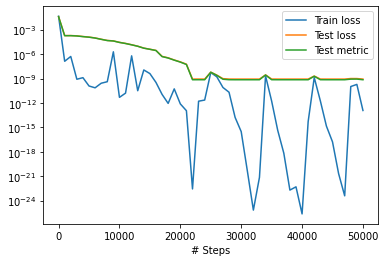

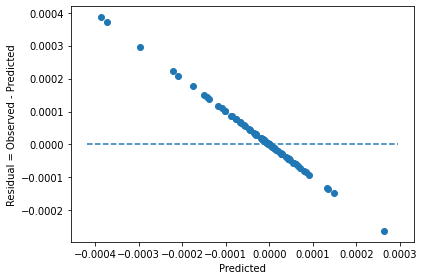

Restoring model from model/model.ckpt-40000 ...

INFO:tensorflow:Restoring parameters from model/model.ckpt-40000
Test MSE: 8.547383905853927e-10
Test MSE w/o outliers: 7.058931188232257e-10

/usr/local/lib/python3.7/site-packages/deepxde/metrics.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  return np.linalg.norm(y_true - y_pred) / np.linalg.norm(y_true)
L2relative error: inf
L2relative error: inf
L2relative error: inf
L2relative error: inf


In [5]:
problem = "ode"
T = 1
system = ode_system(T)


# Function space
# space = FinitePowerSeries(N=100, M=1)
# space = FiniteChebyshev(N=20, M=1)
# space = GRF(2, length_scale=0.2, N=2000, interp="cubic")  # "lt"
space = GRF(1, length_scale=0.2, N=1000, interp="cubic")
# space = GRF(T, length_scale=0.2, N=1000 * T, interp="cubic")

# Hyperparameters
m = 100
num_train = 100
num_test = 1000
lr = 0.001
epochs = 50000

# Network
nn = "opnn"
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 1 if problem in ["ode", "lt"] else 2
if nn == "opnn":
    net = dde.maps.OpNN(
        [m, 40, 40],
        [dim_x, 40, 40],
        activation,
        initializer,
        use_bias=True,
        stacked=False,
    )
elif nn == "fnn":
    net = dde.maps.FNN([m + dim_x] + [100] * 2 + [1], activation, initializer)
elif nn == "resnet":
    net = dde.maps.ResNet(m + dim_x, 1, 128, 2, activation, initializer)

run(problem, system, space, T, m, nn, net, lr, epochs, num_train, num_test)